In [ ]:
!pip install -U langgraph langsmith "langchain[google-genai]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requi

In [ ]:
# いらないかも
import google.generativeai as genai

genai.configure()

In [ ]:
from google.colab import auth

auth.authenticate_user()

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

# vertex AIのAPI-key
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=1,
    max_tokens=256,
    timeout=None,
    max_retries=2,
)

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

import os
from langchain.chat_models import init_chat_model

In [ ]:
# 1. Graphviz 本体と開発ヘッダをインストール
!apt-get update -y
!apt-get install -y graphviz graphviz-dev pkg-config

# 2. Python の依存を再インストール
!pip install --no-cache-dir pygraphviz
from IPython.display import Image, display

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 384 kB in 1s (271 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pac

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate

class State(TypedDict):
  messages: Annotated[list, add_messages]
  initial: bool
  options: list[list[str]]

graph_builder = StateGraph(State)

In [ ]:
# app.py
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import List, Optional

import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph
from typing_extensions import TypedDict, Annotated

app = FastAPI(title="MBTI Chatbot API")

# Initialize Gemini model (similar to your notebook)
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=1,
    max_tokens=256,
    timeout=None,
    max_retries=2,
)

# Define state management (from your notebook)
def add_messages(messages, new_messages):
    return messages + new_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    initial: bool
    options: list[list[str]]

# Define the graph builder
graph_builder = StateGraph(State)

# Set up prompts and graph similar to your notebook
# ... (include relevant code from chatbot_v0.ipynb)

In [ ]:
chatbot_system_prompt_template = "あなたは優秀な性格診断AIです。"\
                                 "ユーザーとAIのチャットの履歴を確認してユーザーの性格を判断する際に参考になる情報を引き出せるような質問をしてください。"\
                                 "特に、MBTIにおける{element}についての情報を得られるような質問をしてください。"\
                                 "ユーザーへの質問は100文字程度で、なるべくyes-noで答えられないものにしてください。"\
                                 "ユーザーの返答の内容についてさらに掘り下げる形で質問をすることが好ましいです。"

chatbot_system_prompt = chatbot_system_prompt_template.format(element = "外向性 or 内向性")
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            chatbot_system_prompt,
        ),
        ("{messages}"),
    ]
)

chain = prompt | llm

def chatbot(state):
  """メインのchat bot部分 userとaiのメッセージが追加されていく"""
  if state.get("initial"):
    return{"messages": [chain.invoke(state["messages"])],
           "initial": False}
  else:
    return{"messages": [chain.invoke(state["messages"])]}


In [ ]:
def _combine_options_list(options_list: list[str]) -> str:
  """今まで生成された回答の候補のリストをstrに"""
  if len(options_list) == 0:
    options_str = "まだ候補がありません"
  else:
    options_str = "\n".join(options_list)
  return options_str


def _organaize_chat_history(raw_messages):
  messages = "\n".join(
      f"{msg.type}: {msg.content}" for msg in raw_messages)
  return messages


gen_user_message_prompt = "あなたは会話補助用のAIアシスタントです。 " \
                          "AIのユーザーに対する返答を参考に、それに対するユーザーの返答の候補を1つ生成してください。\n"\
                          "返答の候補は50文字以内の簡潔なものとし、それ以外のもの(human: や　＞　など)は出力しないでください \n"\
                          "{messages}\n"\
                          "ただし、以下の返答の候補以外のものを提示してください\n"\
                          "{options}"


def gen_user_message_options(state, num_options=3):
  """回答の候補のリストを生成"""
  options_list = []
  messages = _organaize_chat_history(state["messages"])
  for i in range(num_options):
    options = _combine_options_list(options_list)
    prompt = gen_user_message_prompt.format(messages=messages, options=options)
    option = llm.invoke(prompt)
    options_list.append(option.content)

  state["options"].append(options_list)
  return state

In [ ]:
# nodeの追加
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("user_assist_llm", gen_user_message_options)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", "user_assist_llm")
graph_builder.add_edge("user_assist_llm", END)

graph = graph_builder.compile()

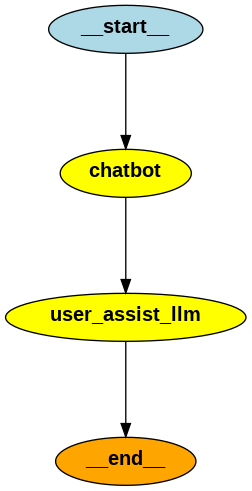

In [ ]:
display(Image(graph.get_graph().draw_png()))

In [ ]:
import random

questions_list = ["最近できた友達はどんな人？",
                 "今週中に締め切りの課題がまだ終わっていないときどうする？",
                 "どうしても気が合わない人がいるときにどうする？"]

initial_question = random.choice(questions_list)
print(initial_question)

どうしても気が合わない人がいるときにどうする？


In [ ]:
# graphの実行
def stream_graph_updates(user_input: str):
  cnt = 0
  for event in graph.stream({"messages": [{"role": "user", "content": user_input}],
                             "options" : []}):
    for value in event.values():
      if cnt == 0:
        print("Assistant:", value["messages"][-1].content)
        print("\n")
        cnt += 1
  print(value["options"])

def stream_graph_updates_initial(user_input: str, question):
  cnt = 0
  for event in graph.stream({"messages": [{"role": "ai", "content": initial_question},
                                            {"role": "user", "content": user_input}],
                             "options": []}):
    for value in event.values():
      if cnt == 0:
        print("Assistant:", value["messages"][-1].content)
        print("\n")
        cnt += 1
  print(value["options"])

cnt = 0
while True:
  if cnt == 0:
    print("Assistant:" , initial_question)
    user_input = input("User: ")
    print("\n")
    stream_graph_updates_initial(user_input, initial_question)
    cnt += 1
  else:
    user_input = input("User: ")
    print("\n")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input)
    cnt +=1

Assistant: 今週中に締め切りの課題がまだ終わっていないときどうする？
User: 諦める


Assistant: 課題を諦める決断をした時、誰かに相談したり、状況を共有したりすることはありますか？ それとも、一人で抱え込むことが多いでしょうか？


[['誰にも言わず、そっと諦めます。', '友達に愚痴るかも。', '先生に相談してみるかも。']]
User: 友達に愚痴るかも


Assistant: なるほど、友達に愚痴ることがあるんですね。どんな時に、誰に愚痴ることが多いですか？また、愚痴った後、どのように気持ちが変化しますか？


[['聞いてくれてありがとう', '誰にでも愚痴るよ。', 'ストレスが溜まった時かな。']]
User: 誰にでも愚痴るよ


Assistant: 愚痴を言う時、あなたはどんな場所や状況を選びますか？また、愚痴を聞いてくれる人に何を期待しますか？


[['聞いてくれるだけでいいかな。', '場所は選ばないな。', '共感してくれると嬉しいな。']]
User: q


Goodbye!
